In [74]:
import pandas as pd
import numpy as nm
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA
from pyspark.sql.functions import mean
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import random

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [75]:
spark = SparkSession.builder.appName("PCA").getOrCreate()
sqlContext = SQLContext(spark)

/storage/home/jjw5989/.local/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [76]:
encoded_df = pd.read_csv("./preprocessed_data.csv", low_memory=False,index_col=0)

In [77]:
encoded_df.drop(['Case Number', 'IUCR','Date','Block','FBI Code','Description', "Loc_Descr_Int", "Prim_Type_Int"],axis=1,inplace=True)

In [78]:
feature_columns = encoded_df.columns
feature_columns = list(feature_columns)
feature_columns

['Arrest',
 'Domestic',
 'District',
 'Ward',
 'Community Area',
 'Year',
 'Latitude',
 'Longitude']

In [79]:
df = sqlContext.createDataFrame(encoded_df)

In [80]:
cols_to_cast = ["District","Ward","Community Area","Year","Arrest","Domestic"]
df = df.select([F.col(c).cast('double') if c in cols_to_cast else c for c in df.columns])

In [81]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(df)

In [82]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

In [83]:
pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

In [85]:
result.printSchema()

root
 |-- Arrest: double (nullable = true)
 |-- Domestic: double (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- Year: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pcaFeatures: vector (nullable = true)



In [86]:
result = result.withColumn('pca1', col('pcaFeatures')[0])
result = result.withColumn('pca2', col('pcaFeatures')[1])

AnalysisException: [INVALID_EXTRACT_BASE_FIELD_TYPE] Can't extract a value from "pcaFeatures". Need a complex type [STRUCT, ARRAY, MAP] but got "STRUCT<type: TINYINT, size: INT, indices: ARRAY<INT>, values: ARRAY<DOUBLE>>".

In [73]:
panads_df = result.select("pca1", "pca2").toPandas()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `pca1` cannot be resolved. Did you mean one of the following? [`Year`, `Ward`, `Arrest`, `features`, `District`].;
'Project ['pca1, 'pca2]
+- Project [Arrest#483, Domestic#484, District#485, Ward#486, Community Area#487, Year#488, Latitude#473, Longitude#474, features#498, scaled_features#545, UDF(scaled_features#545) AS pcaFeatures#584]
   +- Project [Arrest#483, Domestic#484, District#485, Ward#486, Community Area#487, Year#488, Latitude#473, Longitude#474, features#498, UDF(features#498) AS scaled_features#545]
      +- Project [Arrest#483, Domestic#484, District#485, Ward#486, Community Area#487, Year#488, Latitude#473, Longitude#474, UDF(struct(Arrest, Arrest#483, Domestic, Domestic#484, District, District#485, Ward, Ward#486, Community Area, Community Area#487, Year, Year#488, Latitude, Latitude#473, Longitude, Longitude#474)) AS features#498]
         +- Project [cast(Arrest#467 as double) AS Arrest#483, cast(Domestic#468 as double) AS Domestic#484, cast(District#469 as double) AS District#485, cast(Ward#470 as double) AS Ward#486, cast(Community Area#471 as double) AS Community Area#487, cast(Year#472 as double) AS Year#488, Latitude#473, Longitude#474]
            +- LogicalRDD [Arrest#467, Domestic#468, District#469, Ward#470, Community Area#471, Year#472, Latitude#473, Longitude#474], false


In [ ]:
def visualize_PCA(df):
    # Set labels and title
    plt.xlabel("PCA_Feature_1")
    plt.ylabel("PCA_Feature_2")
    plt.title("PCA")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

In [55]:
def fit_kmeans(df_input,column_name='pcaFeatures',num_cluster_centers=3):
    '''
    Requires
    df_input: spark dataframe with column name "features" having vector of real-valued inputs
    num_cluster_centers: integer that tells the algorithm the value of k
    column_name: column name (string) that indicates which vector of features to choose
    Returns
    cluster_data: spark dataframe with predictions
    silhouette_score: float with silhouette score
    wcss: float within cluster sum of squares
    '''
    # Create a K-Means instance
    kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
    
    # Fit the K-Means model to the data
    model = kmeans.fit(df_input)
       
    # Get the cluster assignments for each data point
    clustered_data = model.transform(df_input)

    # Evaluate the clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(clustered_data)

    # Print the WCSS (Within-Cluster Sum of Squares)
    wcss = model.summary.trainingCost
    
    # Get the cluster sizes and centers
    cluster_sizes = clustered_data.groupBy("prediction").count()
    cluster_sizes.show()
    
    # Return the clustered data
    return clustered_data, silhouette_score, wcss

In [56]:
def generate_random_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

In [57]:
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
    '''
    Requires:
    clustered_data: dataframe returned from Kmeans fit
    num_cluster_centers: integer number of clusters
    feature_1: string with identifiers for first column name
    feature_2: string with identifiers for second column name
    '''
    
    # Convert the DataFrame to a Pandas DataFrame for visualization
    pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
    
    # Extract the cluster assignments
    cluster_assignments = pandas_df["prediction"]
    
    # Extract the indices for the cluster center
    p1 = feature_columns.index(feature_1)
    p2 = feature_columns.index(feature_2)
    
    # Create a scatter plot for each cluster
    for cluster_id in range(num_cluster_centers):
        # Generate a random color
        random_color = generate_random_color()        
        cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
        plt.scatter(cluster_data[feature_1], cluster_data[feature_2], color=[random_color], label=f'Cluster {cluster_id}')
        plt.scatter(cluster_data[feature_1].mean(),cluster_data[feature_2].mean(), color=[random_color], marker='x', s=500)
    
    # Set labels and title
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title("K-Means Clustering")
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

In [58]:
num_centers = 3
clustered_data, _, _ = fit_kmeans(result,column_name='pcaFeatures',num_cluster_centers=num_centers)

+----------+------+
|prediction| count|
+----------+------+
|         1|124473|
|         2| 94641|
|         0|133252|
+----------+------+



In [59]:
clustered_data.head(1)

[Row(Arrest=0.0, Domestic=0.0, District=2.0, Ward=3.0, Community Area=35.0, Year=2020.0, Latitude=41.830481843, Longitude=-87.621751752, features=DenseVector([0.0, 0.0, 2.0, 3.0, 35.0, 2020.0, 41.8305, -87.6218]), scaled_features=DenseVector([-0.4637, -0.5097, -1.3255, -1.4327, -0.1114, 0.4767, -0.1293, 0.8075]), pcaFeatures=DenseVector([-1.564, 0.3683, -1.0406, 0.2879, 0.6409, -0.993]), prediction=0)]

/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


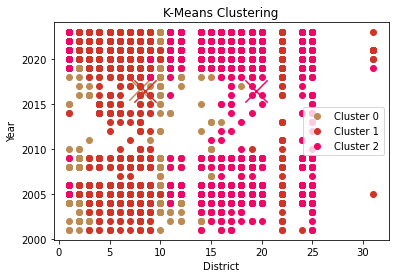

In [60]:
feature_1 = "District"
feature_2 = "Year"

visualize_clusters_2D(clustered_data, feature_1, feature_2, num_centers)